## LangGraph: Multi-Agent Workflow

This notebook will focus on the exploration of LangGraph and Agentic Workflow, focusing on a basic Agentic RAG. By the end of this workshop you should:
1. Have a basic understanding of AgenticRAG
2. Basic knowledge of how to create Nodes and Edges of LangGraph
3. Able to run a simple Agentic LangGraph workflow

As this tutorial will be showing you how to build a simple Q&A application over a CSV text data source, we will go over a typical Q&A architecutre and highlight additional resources for more advanced Q&A techniques.

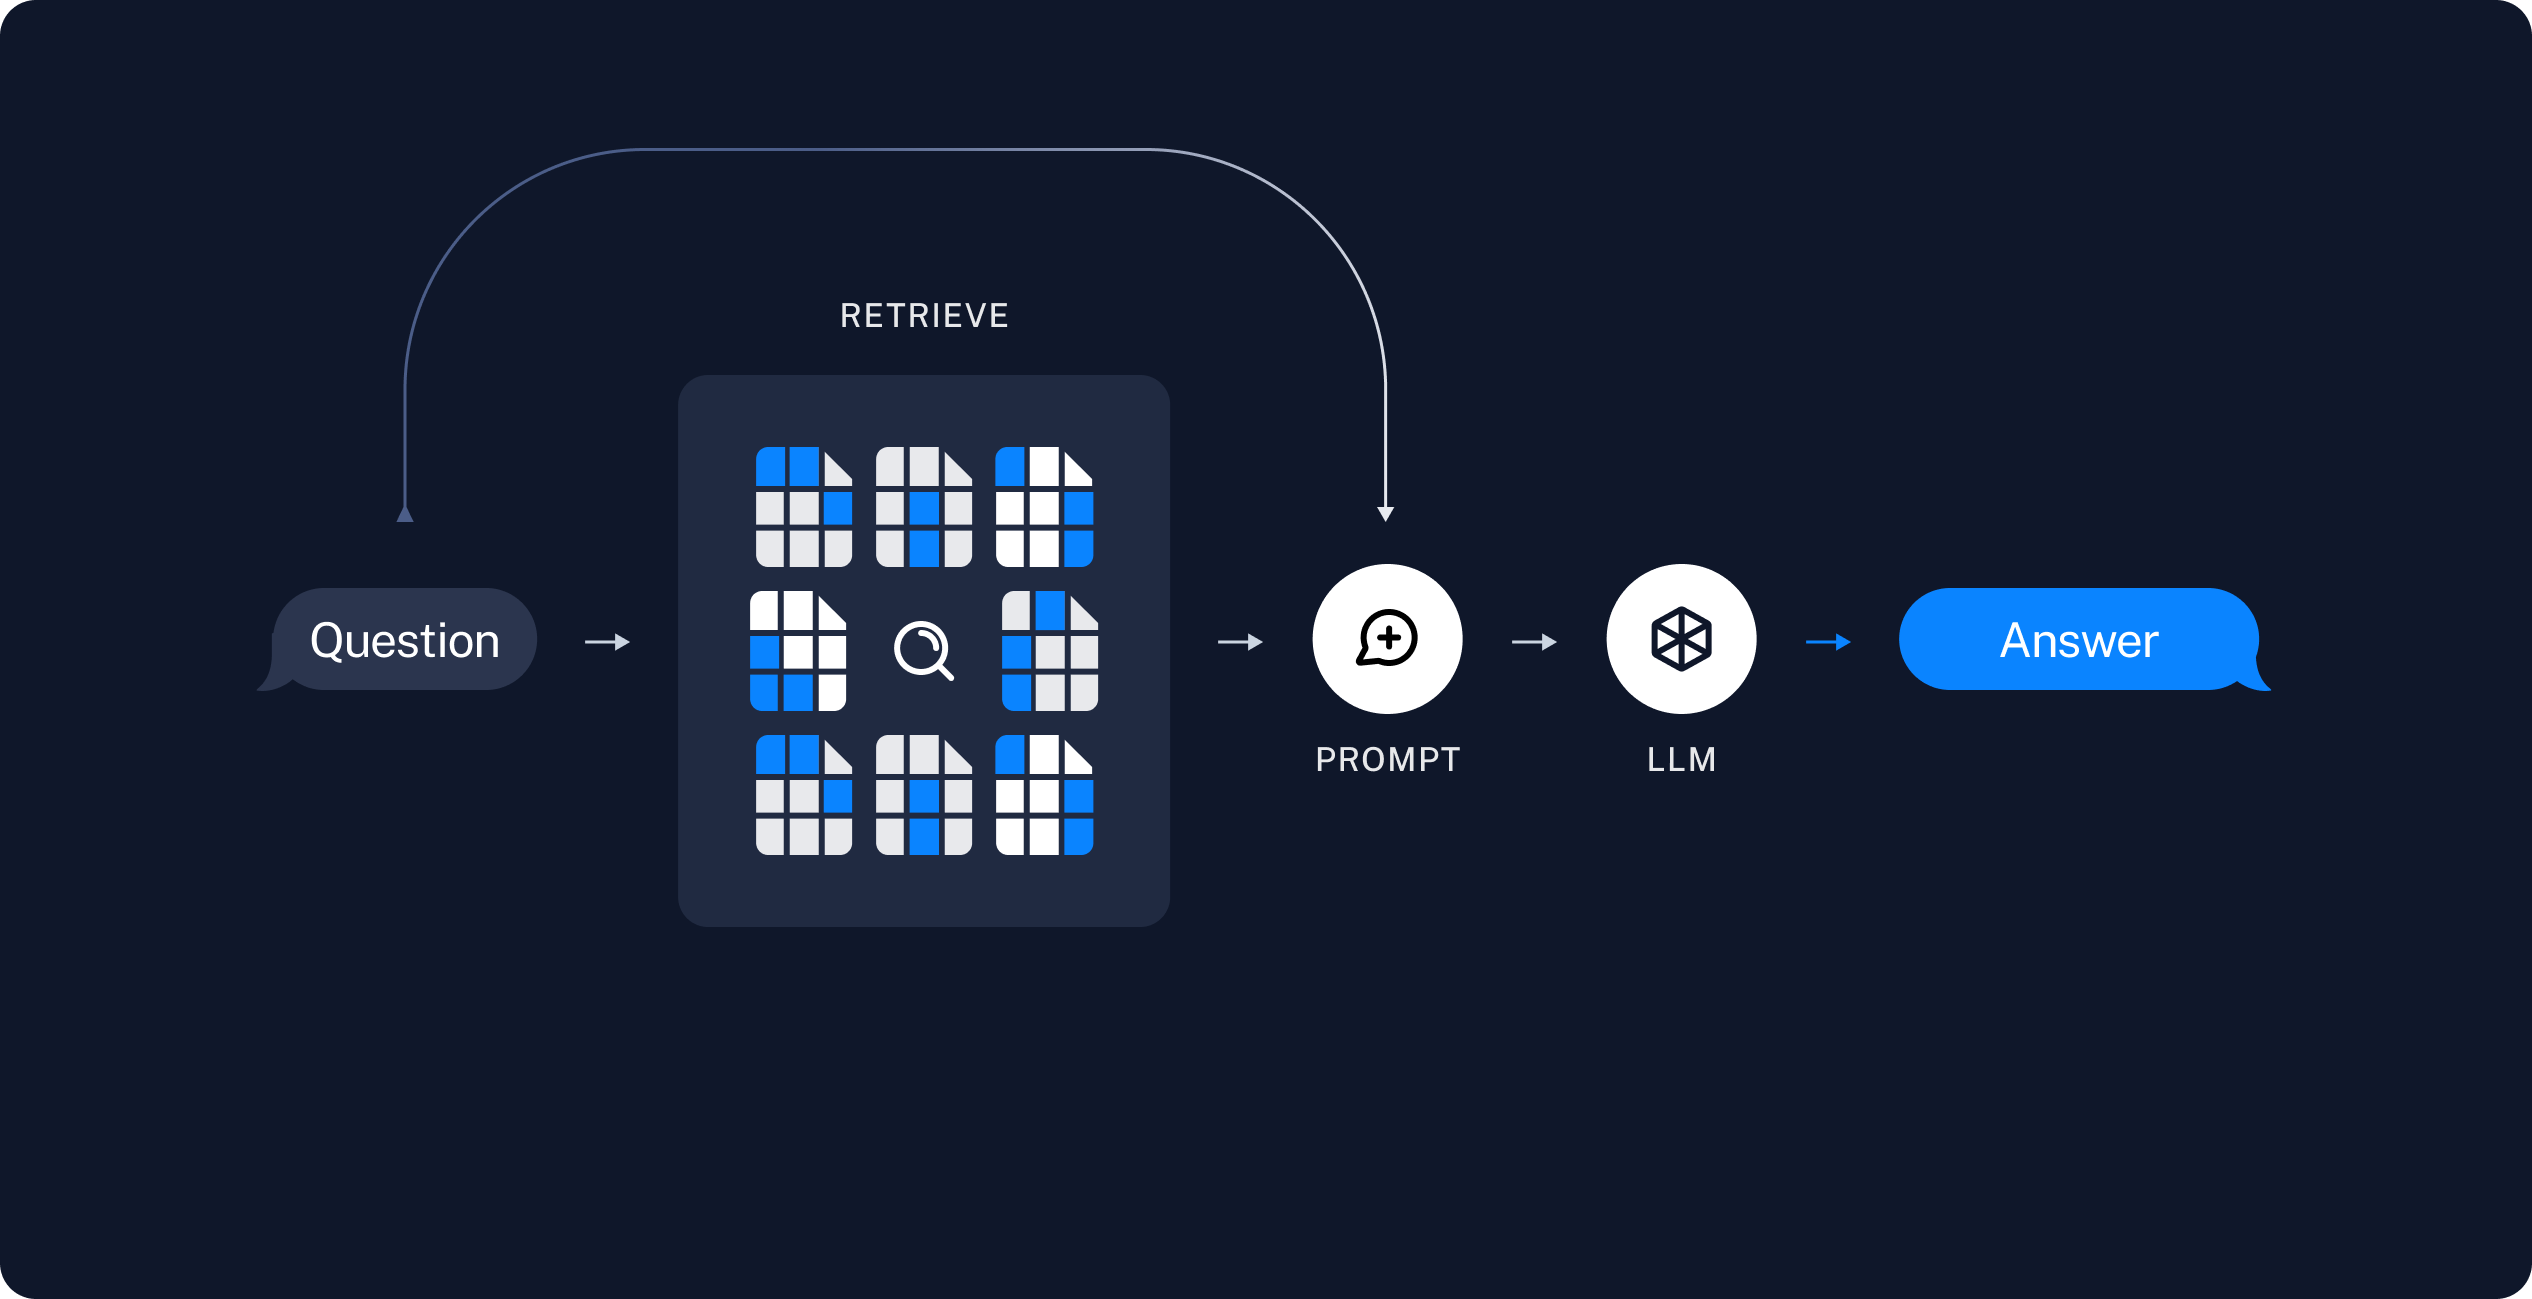

In [22]:
from dotenv import load_dotenv 
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
load_dotenv(override=True)

# Setting up of Azure LLM

# 1. Azure OpenAI (GPT-4o-mini)
azure_llm = AzureChatOpenAI(model="gpt-4o-mini", temperature=0)

# 2. Azure Text Embedding (Text-embedding-ada-002)
embedding_function = AzureOpenAIEmbeddings(model="text-embedding-ada-002")

In [23]:
# Testing out Azure LLM
response = azure_llm.invoke("Hello, how are you?")
response.content

"Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?"

## Retriever Function 
We will begin with the retriever function where it uses the user query to retrieves relevant data from the index in order to pass to the model.

### Indexing of data
1. Load: First we need to load our data. This is done with CSVLoader
2. Split: Text splitters to break large Documents into smaller chunks. This can be useful for both indexing data and passing it into a model, as large chunks are harder to search over and won't fit in a model's finite context window.
3. Store: We need somewhere to store and index our splits (ChromaDB), so that they can be searched over later.

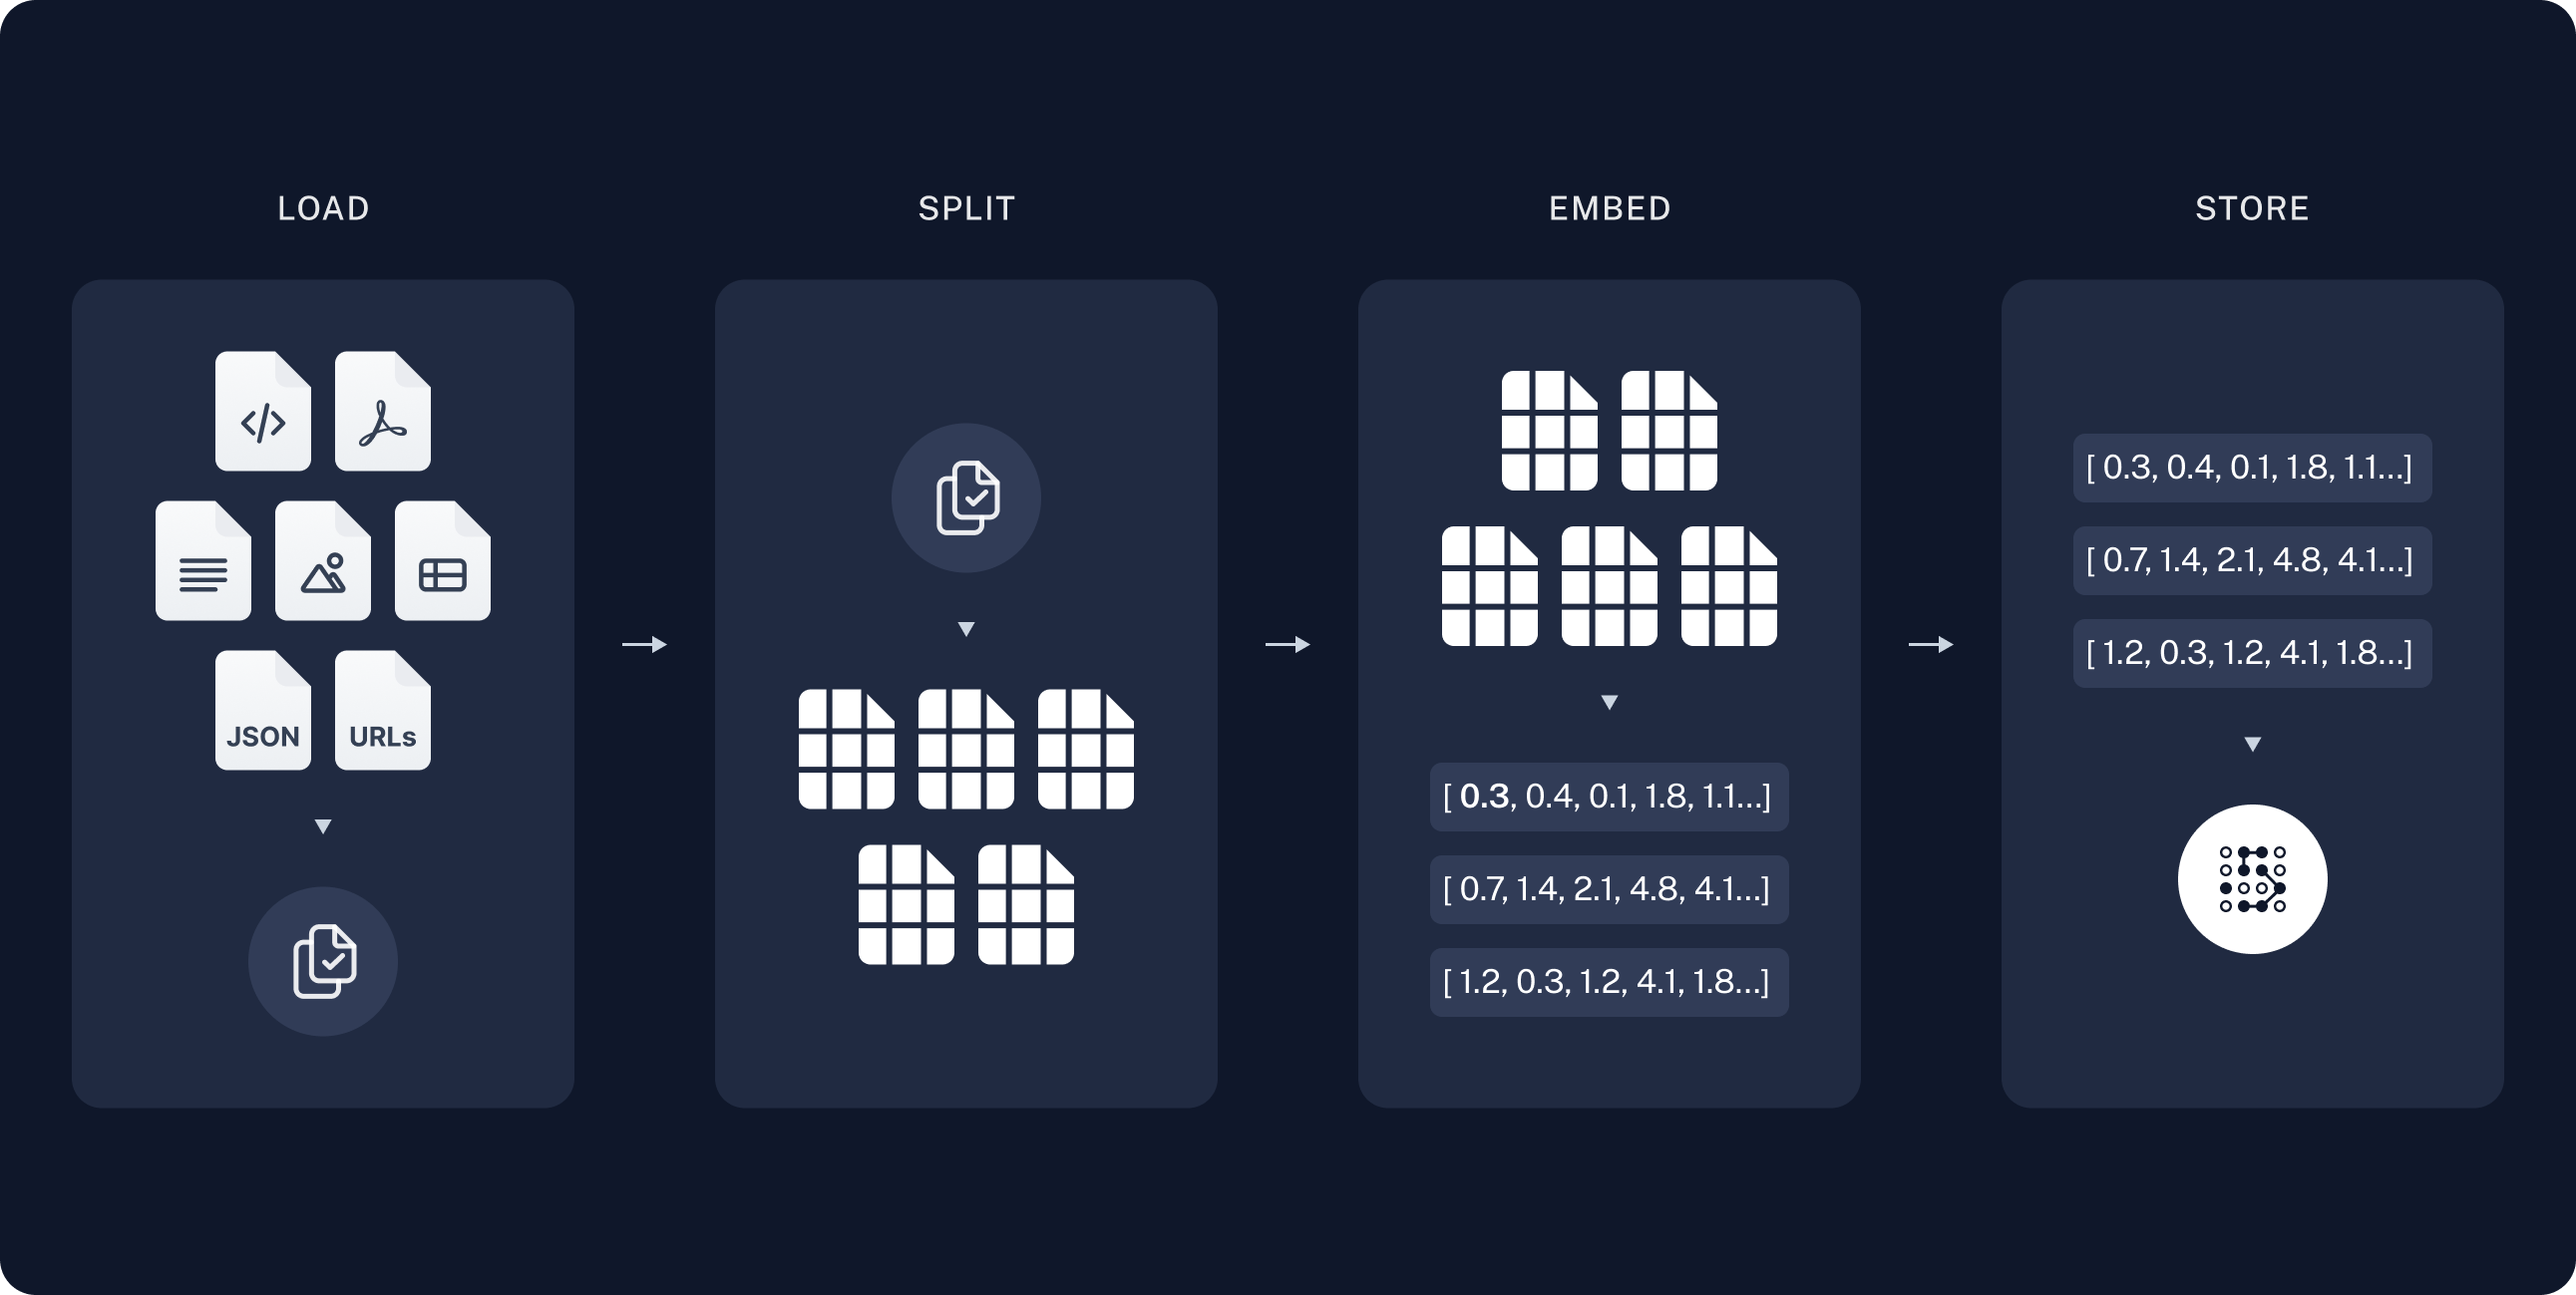

In [31]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_chroma import Chroma
from langchain_openai import AzureOpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from dotenv import load_dotenv 
from langchain_community.vectorstores import FAISS

load_dotenv(override=True)


# Previously, we have seen how to use PdfLoaders, today we will be introducing CSVLoader 
def vector_stores():
    # 1. Load our data using Document Loaders (CSVLoader) - other DocumentLoader tools on LangChain
    loader = CSVLoader(
        file_path="./data/courses.csv",
        csv_args = {
            "delimiter": ",",
            "quotechar": '"',
            "fieldnames": [
                "courseCode",
                "academicUnits",
                "description",
                "intendedLearningOutcomes",
                "semester",
                "prerequisites",
                "school",
                "yearStanding"
            ]
        }
    )

    # Load the CSV data into a format that LangChain can process, called 'documents'
    docs = loader.load()

    # 2. Split: Text splitter break large Documents into smaller chunks. Useful for both indexing data and for passing it into a model, since large chunks are harder to search over.
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
    splits = text_splitter.split_documents(docs)

    # 3. Store it in Chroma VectorStores and Saves it to disk
    embedding_function = AzureOpenAIEmbeddings(model="text-embedding-ada-002")
    # Chroma is an alternative to FAISS
    vectorstore = Chroma.from_documents(
        documents = splits, embedding = embedding_function, persist_directory = "./chroma_db"
    )
    # FAISS vectorstore
    # faiss_vectorstore = FAISS.from_documents(splits, embedding_function)

    return vectorstore

In [32]:
vectorstores = vector_stores()

## Creating Retriever Tool

In [5]:
from langchain.tools.retriever import create_retriever_tool

# Load vectorstores from disk
vectorstores = Chroma(
    persist_directory = "./chroma_db", embedding_function = AzureOpenAIEmbeddings(model="text-embedding-ada-002")
)

# Create the retriever 
retriever = vectorstores.as_retriever(search_type="similarity", search_kwargs={"k":5})

# Create the retriever tool
retriever_tool = create_retriever_tool(
    retriever, 
    "retrieve_course_information",
    "Search and return information related to College of Computing and Data Science Courses"
)

tools = [retriever_tool]

## AgenticRAG 

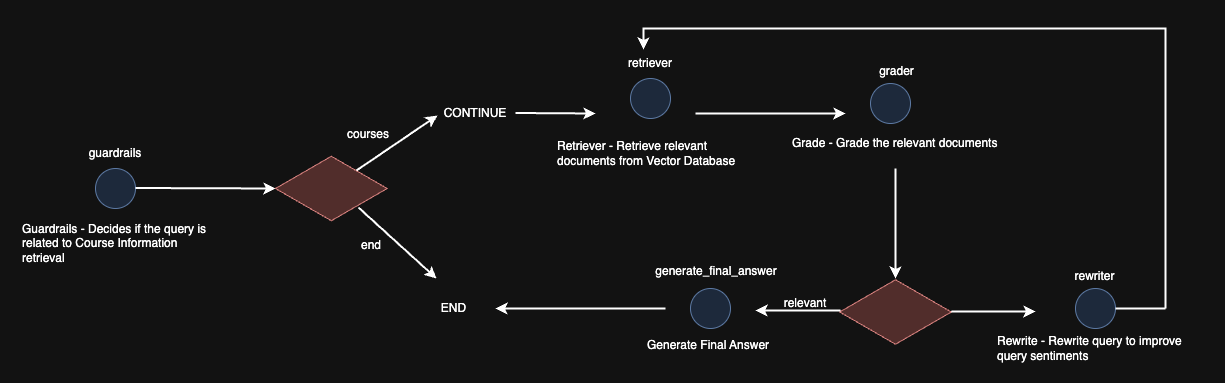

Guardrails: The process starts with guardrails, which ensure the input query is relevant to course information retrieval. If the query does not meet this criterion, the workflow ends here.

Courses Node: If the query is valid, it proceeds to the next step. This node indicates that the query continues to explore the relevant data.

Retriever: At this stage, the retriever searches for relevant documents or information from the vector database based on the query.

Grader: The retrieved documents are then graded for relevance and quality. This step ensures that only the most useful and accurate information is considered.

Rewriter: If needed, the query is rewritten to improve its clarity or sentiment. This helps refine the process for better results.

Generate Final Answer: Finally, the relevant documents and improved query feed into the answer generation stage. This step synthesizes the data and provides a comprehensive response to the user query.

We will now be defining our graph. 

## State
State is the information that can be passed between nodes in a whole graph. If you want to keep track of specific information during the workflow then you can use state. 

There are 2 types of graphs which you can make in LangGraph: 
- Basic Graph: The basic graph will only pass the output of the first node to the next node because it can’t contain states. 
- Stateful Graph: This graph can contain a state which will be passed between nodes and you can access this state at any node.


In [6]:
import operator
from typing import Annotated, Sequence, List
from typing_extensions import TypedDict 
from pydantic import BaseModel # A base class for creating Pydantic models.
from langchain_core.documents import Document

# Create States for the graph

# Capture the initial suer input or query
class InputState(TypedDict):
    query: str

# Track the workflow's progress, intermediate results, next steps, and retrieved data
class OverallState(TypedDict):
    query: Annotated[Sequence[BaseModel], operator.add] # operator.add -> enable aggregation of queries or steps 
    next_action: str
    steps: Annotated[List[str], operator.add] 
    database_records: List[dict | Document] 

# Stores the final result (answer) and logs the steps for transparency
class OutputState(TypedDict):
    answer: str 
    steps: List[str]

## Nodes
Nodes in LangGraph represent individual functions or tools that your AI agent can use. These can be anything from API calls to complex reasoning tasks performed by language models. Each node is a discrete step in your workflow that processes input and produces output.


In [7]:
from langchain_core.messages import HumanMessage 
from langchain_core.output_parsers import StrOutputParser

In [8]:
# 1. Guardrail Agent - Check if the query is related or not --> If is not we will generate final answer directly
from typing import Literal 
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field 

class GuardrailsOutput(BaseModel):
    decision: Literal["courses", "end"] = Field(
        description="Decision on whether the question is related to courses"
    )

def guardrails(query: str):
    # System Instruction to determine the query's relevance 
    guardrails_system = """
                        As an intelligent assistant, your primary objective is to decide whether a given question is related to courses or degrees or not. 

                        If the question is related to either courses or degree information, output "courses". Otherwise, output "end". 

                        To make htis decision, assess the content of the question and determine if it refers to any course data, pre_requisite, curriculum details, degree data, or related topics. 

                        Provide only the specified output: "courses" or "end". 
                        """
    
    # Guardrail chain
    guardrails_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                guardrails_system,
            ),
            (
                "human",
                ("{question}"),
            ),
        ]
    )

    guardrails_chain = guardrails_prompt | azure_llm.with_structured_output(GuardrailsOutput)

    # Execute the pipeline
    guardrails_output = guardrails_chain.invoke({"question": query})
    print(guardrails_output)

    return guardrails_output

In [9]:
def guardrails_node(state: InputState) -> OverallState:
    """
    Decides if the question is related to courses or not.
    """
    # Retrieve query
    query = state.get("query")
    # Invoke Guardrails
    guardrails_output = guardrails(query)
    database_records = None 
    if guardrails_output.decision == "end":
        database_records = "This question is not related to course planning. Therefore, I cannot answer this question."
    
    # Return updated state
    return {
        "next_action": guardrails_output.decision,
        "database_records": database_records, 
        "steps": ["guardrail"],
    }
    

In [11]:
# 2. Vector Retriever (Retrieved data from ChromaDB)
def vector_retriever(query: str):
    # Load ChromaDB from disk
    vectorstores = Chroma(
        persist_directory = "./chroma_db", embedding_function=embedding_function
    )
    retriever = vectorstores.similarity_search(query)
    print(retriever)
    return {"context": retriever}


In [12]:
def vector_retriever_node(state: OverallState) -> OverallState:
    """
    Retrieved information from VectorDB
    """
    query = state.get("query")[-1]
    retrieved_results = vector_retriever(query)

    # Update the states
    return {
        "next_action": "grade_document",
        "database_records": retrieved_results,
        "steps": ["retriever"]
    }


In [10]:
# 3. Grade Document Agent

# Data model 
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: Literal["relevant", "irrelevant"] = Field(
        description = "Documents are relevant to the question, 'relevant' or 'irrelevant'"
    )

def grade_documents(query, retrieved_results):
    structured_llm_grader = azure_llm.with_structured_output(GradeDocuments)
    # Prompt
    system = """
             You are a grader assessing relevance of a retrieved document to a user question. \n
             If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
             Document retrieved can be in the form of list or json object, you are to examine these information closely. \n

             Based on the given example, if the retrieved format is formatted similarly, then the document retrieved is relevant.
             Give a binary score 'relevant' or 'irrlevant' score to indicate whether the document is relevant to the question.
             """
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Query: {query}\ndocument:{document}"),
        ]
    )

    retrieval_grader = grade_prompt | structured_llm_grader
    results = retrieval_grader.invoke({"document": retrieved_results, "query": query})
    return results

In [13]:
def grade_documents_node(state: OverallState) -> OverallState:
    """
    Grade to check if documents retrieved are relevant
    """
    query = state.get("query")[-1]
    retrieved_results = state.get("database_records")
    grade_response = grade_documents(query, retrieved_results)
    
    return {
        "next_action": grade_response.binary_score,
        "steps": ["grade"]
    }

In [14]:
# 4. Generate Final Answer
def generate_final_answer(query, retrieved_results):
    generate_final_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful assistant",
            ),
            (
                "human",
                (
                    """Use the following results retrieved from a database to provide succint, definitive answer to the user's question.
                    
                    Respond as if you are answering the question directly. 

                    Results: {results}
                    Question: {question}
                    """
                ),
            ),
        ]
    )

    generate_final_chain = generate_final_prompt | azure_llm | StrOutputParser()
    final_answer = generate_final_chain.invoke(
            {"question": query, "results": retrieved_results}
        )

    return final_answer

In [15]:
def generate_final_answer_node(state:OverallState) -> OutputState:
    """
    Decides if the question is related to course planning.
    """
    query = state.get('query')[-1]
    retrieved_results = state.get('database_records')
    final_answer = generate_final_answer(query, retrieved_results)

    print("Final Answer: ", final_answer)
    return {
        "answer": final_answer, 
        "steps": ["generate_final_answer"]
        }

In [16]:
# 5. Rewrite query agent 
def rewrite(query):
    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {query} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    response = azure_llm.invoke(msg)

    return response

In [17]:
def rewrite_node(state: OverallState) -> OverallState:
    query = state.get("query")[-1]
    new_query = rewrite(query)

    return {
        "query": new_query,
        "steps": ["rewriter"]
    }

## Defining Conditional Edges

We can define the `conditional_edges`.

`edges` route the control flow from one node to the next. While Conditional Edges usually contain "if" statements to route to different nodes depending on the current graph state. These functions receives the current graph `state` and return a string or list of strings indicating which node(s) to call next.

In [19]:
# To determine the next node after the guardrail node, based on the value of the next_action field in the state.
def guardrails_condition(
    state: OverallState
) -> Literal["retriever", "generate_final_answer"]:
    if state.get("next_action") == "end":
        return "generate_final_answer"
    elif state.get("next_action") == "courses":
        return "retriever"

def grade_condition(
    state: OverallState
) -> Literal["generate_final_answer", "rewriter"]:
    if state.get("next_action") == "relevant":
        return "generate_final_answer"
    elif state.get("next_action") == "irrlevant":
        return "rewriter"

## Defining Workflow

Define the entry points and all the graph edges accordingly.
First, we need to set the entry point for graph execution - agent node.

Then we define normal and conditional edges. Conditional edge means that the destination depends on the content of the graph's state. 
Normal edges: occurs after the tools are invoked, the graph should always return to the decide what to do next.

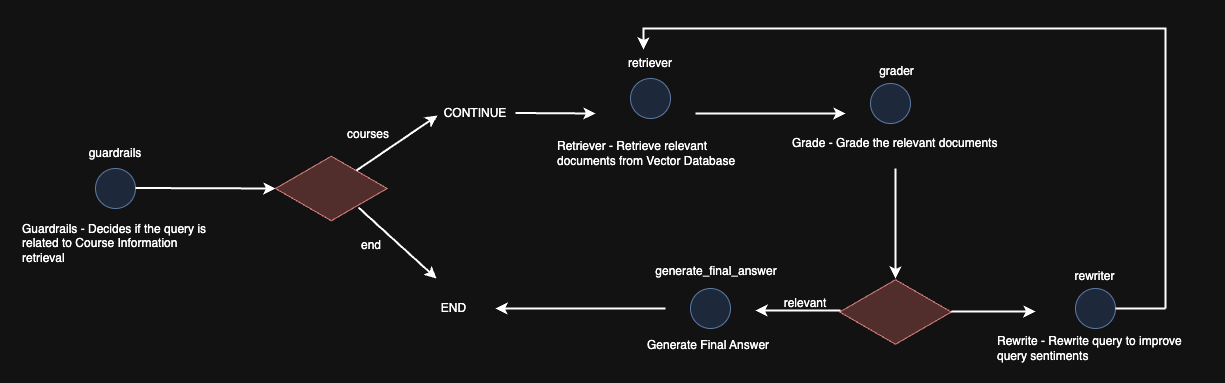

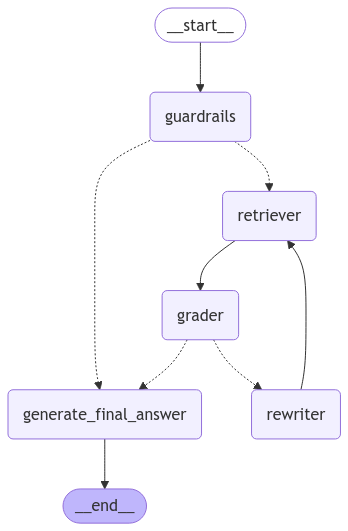

In [20]:
from IPython.display import Image, display 
from langgraph.graph import END, StateGraph, START

# 1. Define a new graph
workflow = StateGraph(OverallState, input=InputState, output=OutputState)

# 2. Define Nodes (Agents)
workflow.add_node("guardrails", guardrails_node)
workflow.add_node("retriever", vector_retriever_node)
workflow.add_node("grader", grade_documents_node)
workflow.add_node("generate_final_answer", generate_final_answer_node)
workflow.add_node("rewriter", rewrite_node)

# 3. Define Edges
workflow.add_edge(START, "guardrails")
workflow.add_conditional_edges(
    "guardrails",
    guardrails_condition
)
workflow.add_edge("retriever", "grader")
workflow.add_conditional_edges(
    "grader",
    grade_condition
)
workflow.add_edge("rewriter", "retriever")
workflow.add_edge("generate_final_answer", END)

# 4. Compile the graph
graph = workflow.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Execution of Graph

In [21]:
results = []
for s in graph.stream(
    {
        "query": ["Tell me more about Artificial Intelligence Course"]
    }
):
    if "__end__" not in s:
        print(s)
        print("----------------")

        if 'generate_final_answer' in s:
            results.append(s['generate_final_answer']['answer'])

print("FINAL ANSWER:")
print(results[0])

decision='courses'
{'guardrails': {'next_action': 'courses', 'database_records': None, 'steps': ['guardrail']}}
----------------
[Document(id='fcb526cc-c64b-4a0c-b290-2299ab4e1733', metadata={'row': 16, 'source': './data/courses.csv'}, page_content='courseCode: SC3000\nacademicUnits: 3\ndescription: Artificial Intelligence\nintendedLearningOutcomes: Computer / software engineers are involved in effective and efficient building of knowledge agent systems that satisfy the requirements of users; possibly software for intelligent embedded and intelligent information systems. General awareness of theory, knowledge, and practice in all phases of the knowledge based systems and representation techniques for problem solving are necessary for those of you who wants to get into the field artificial intelligence. These are advanced intelligent systems that are finding widespread applications in finance, banking, manufacturing industries.\nsemester: \nprerequisites: 1,2\nschool: SC1007, SC1015, [S